In [1]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import missingno as msno


# Домашнее задание к лекции "Статистика. Практика"
## Задание 1

Данные о видеоиграх

Ответьте на следующие вопросы:

1) Как критики относятся к спортивным играм?

2) Критикам нравятся больше игры на PC или на PS4?

3) Критикам больше нравятся стрелялки или стратегии?

Для каждого вопроса:
- сформулируйте нулевую и альтернативную гипотезы;
- выберите пороговый уровень статистической значимости;
- опишите полученные результаты статистического теста.


In [3]:
# Загружаем датасет
videogames_df = pd.read_csv('video_games_sales.csv')
videogames_df


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55787,55788,Indivisible,indivisible,Role-Playing,NaN,PC,505 Games,Lab Zero Games,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.0,11th Apr 19,http://www.vgchartz.com/game/224682/indivisibl...,1,NaN,/games/boxart/full_6339426AmericaFrontccc.jpg
55788,55789,Lost Ember,lost-amber,Adventure,RP,PC,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.0,11th Apr 19,http://www.vgchartz.com/games/game.php?id=2246...,1,NaN,/games/boxart/full_8893129AmericaFrontccc.jpg
55789,55790,Lost Ember,lost-amber,Adventure,RP,PS4,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.0,11th Apr 19,http://www.vgchartz.com/game/224690/lost-ember...,1,NaN,/games/boxart/full_6514293AmericaFrontccc.jpg
55790,55791,Lost Ember,lost-amber,Adventure,RP,XOne,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.0,11th Apr 19,http://www.vgchartz.com/game/224688/lost-ember...,1,NaN,/games/boxart/full_6799693AmericaFrontccc.jpg


Для задания нам понадобятся только следующие колонки:
- Genre
- Platform
- Critic_Score

Посмотрим на данные и пропуски в этих колонках


In [4]:
# Основные статистики
videogames_df['Critic_Score'].describe()


count    6536.000000
mean        7.213709
std         1.454079
min         1.000000
25%         6.400000
50%         7.500000
75%         8.300000
max        10.000000
Name: Critic_Score, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55792 entries, 0 to 55791
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genre         55792 non-null  object 
 1   Platform      55792 non-null  object 
 2   Critic_Score  6536 non-null   float64
dtypes: float64(1), object(2)
memory usage: 871.8+ KB


<AxesSubplot:>

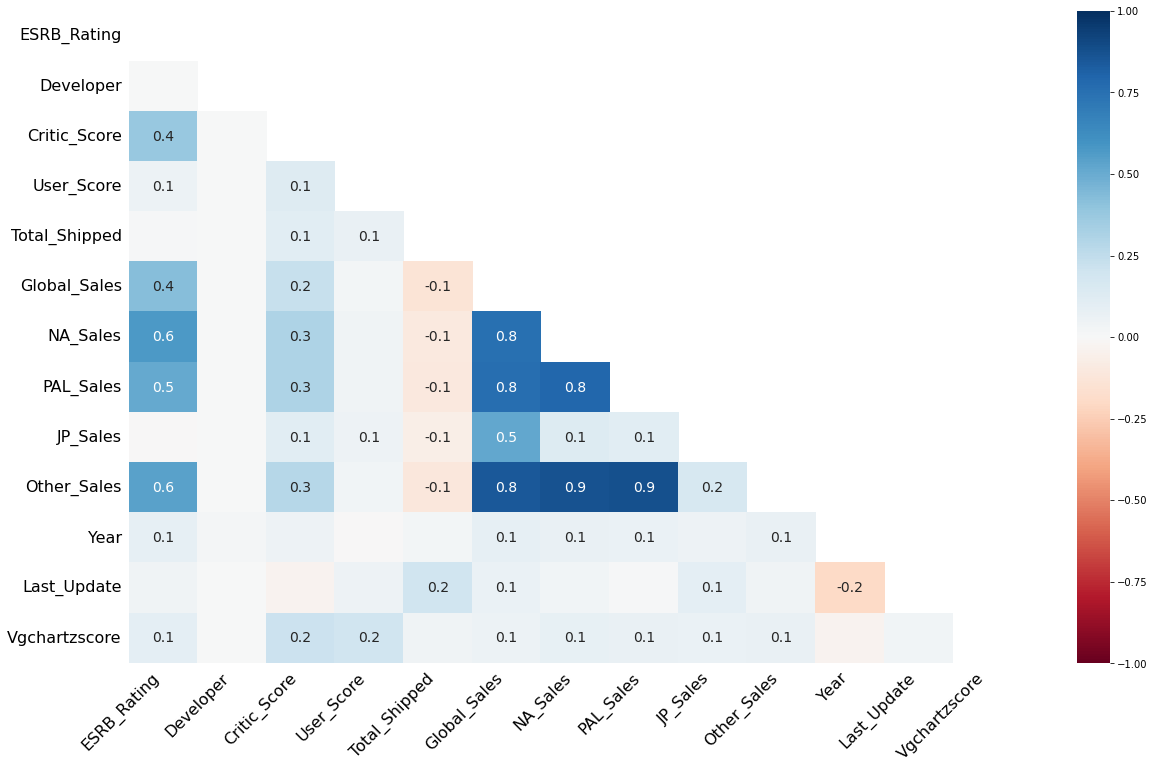

In [5]:
# Пропуски
videogames_df[['Genre', 'Platform', 'Critic_Score']].info()
msno.heatmap(videogames_df)


Для большей части записей (ок. 90%) отсутствует информация об оценке критиками.
При этом пропуски в Critic_Score практически не коррелируют с пропусками в других колонках.

Есть основания полагать, что характер пропусков - MAR, missing at random -
на отсутствие переменной скорее всего влияет третий фактор, который в данных не присутствует.

В этом есть и смысл - игру могли не оценить в силу непопулярности/нишевости, игра только вышла, еще
не набралось достаточно оценок, у критиков, чьи оценки тут присутствуют есть специализация на определенных играх и т.д.

Предмет данного исследования - предпочтения критиков.
Поэтому, чтобы не исказить информацию, лучшим решением будет убрать из анализа записи с отсутствующим Critic_Score,
а не пытаться заменить на средние значения.

Если бы у нас имелось больше данных о датасете, можно было бы попробовать обогатить данные из других источников.


In [6]:
# Удаляем записи без оценок критиков
games_df = videogames_df.dropna(subset=['Critic_Score'])
games_df[['Genre', 'Platform', 'Critic_Score']].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6536 entries, 0 to 55653
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genre         6536 non-null   object 
 1   Platform      6536 non-null   object 
 2   Critic_Score  6536 non-null   float64
dtypes: float64(1), object(2)
memory usage: 153.2+ KB


Посмотрим достаточно ли у нас данных в каждой группе для проведения тестов


In [7]:
# Категории: спортивные игр, шутеры, стратегии
categories = ['Shooter', 'Sports', 'Strategy']
pd.DataFrame(games_df[ games_df['Genre'].isin(categories) ]['Genre'].value_counts())


,Genre
Shooter,843
Sports,688
Strategy,369


In [8]:
# Платформы
platforms = ['PC', 'PS4']
pd.DataFrame(games_df[ games_df['Platform'].isin(platforms) ]['Platform'].value_counts())


,Platform
PC,865
PS4,109


В каждой категории больше 30 записей, поэтому мы можем использовать параметрические тесты


### Как критики относятся к спортивным играм?
Варианты решения задачи:
Можно сравнить со средней оценкой по всем играм или провести дисперсионный анализ, сравнив все распределения между собой.


### Вариант 1. One-sample t-test. (сравнение со средним значением)

Н0: среднее оценки спортивных игр = общее среднее
Н1: среднее оценки спортивных игры != общее среднее

Пороговый уровень статистической значимости = 0,05


Условия применения t-test:

1. Данные непрерывны (не дискретные).
2. Нормальность распределения (при объеме выборки n< 30).

Несмотря на то, что объем выборки больше 30, проверим данные на нормальность


In [12]:
from functions import visual_normality_check, statistical_normality_test


In [14]:
# статистическая проверка на нормальность
statistical_normality_test(feature_name='Critic_Score', df_name=games_df[ games_df['Genre']=='Sports' ], alpha=0.05)


Critic_Score normality check 

Shapiro-Wilk normality test for Critic_Score
Statistics=0.921, p-value=0.0% 

Shapiro-Wilk: Sample does not look Gaussian (can reject H0) 

D’Agostino’s K^2 normality Test test for Critic_Score
Statistics=119.876, p-value=0.0% 

D’Agostino’s: Sample does not look Gaussian (can reject H0) 



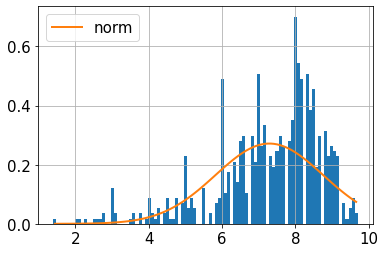

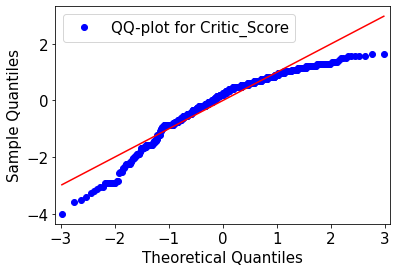

In [15]:
# визуальная проверка на нормальность
visual_normality_check(feature_name='Critic_Score', df_name=games_df[ games_df['Genre']=='Sports' ])


Данные не распределены нормально, смещены вправо.

Причина: значения варьируются от 1 до 10, а критики склонны ставить высокие оценки.
Из-за смешения вправо, правая часть распределения оказывается "отрублена", т.к. оценки заканчиваются на 10.
Для нормального распределения низких оценок не хватает, а высоких слишком много.


<AxesSubplot:>

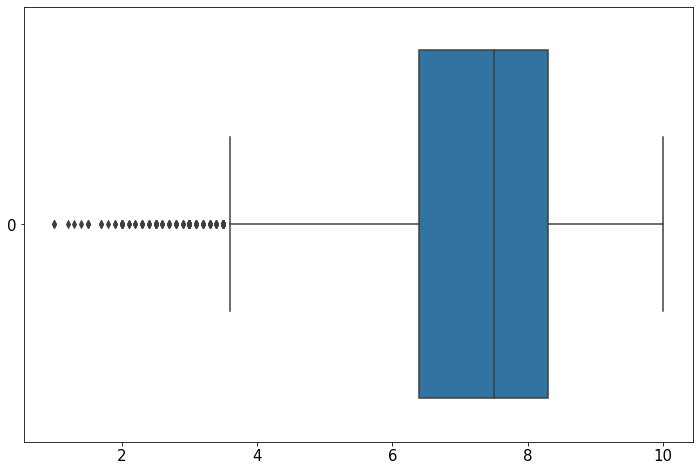

In [16]:
# Посмотрим подробнее на распределение оценок, чтобы выбрать способ расчета среднего значения

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=games_df['Critic_Score'], orient='h')


Несмотря на то, что в данных есть много выбросов слева, среднее лучше всего расcчитать с помощью mean, а не median.
Несмотря на то, что все оценки ниже ~3.7 считаются выбросами, их вряд ли можно считать случайностью -
какие-то игры действительно можно оценить очень низко.
Поэтому важно их включить в расчет среднего значения.

In [17]:
# средняя оценка всех игр вне зависимости от жанра
videogames_all_mean = round(games_df['Critic_Score'].mean(), 3)
videogames_all_mean


7.214

In [18]:
# Сохраним отдельно все оценки критиков, данные спортивным играм
sport_critic_score = games_df[ games_df['Genre'] == 'Sports' ]['Critic_Score']
sport_critic_score.describe()


count    688.000000
mean       7.291424
std        1.470802
min        1.400000
25%        6.500000
50%        7.600000
75%        8.300000
max        9.700000
Name: Critic_Score, dtype: float64

In [19]:
# Проводим t-test, нас интересуют значения как слева так и справа
# - спортивные игры оценивают как хуже, так и лучше,
# поэтому указываем параметр 'two-sided'

alpha = 0.05
result = st.ttest_1samp(sport_critic_score, videogames_all_mean, alternative='two-sided')

print(
        f'One sample t-test results:\n'
        f'Statistic={round(result.statistic,3)}, p-value={round(result.pvalue, 3)}% \n'
    )
# One sample t-test t-test interpret
if result.pvalue > alpha:
    print(
        'Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. \n'
          )
else:
    print(
        'Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. \n'
    )


One sample t-test results:
Statistic=1.381, p-value=0.168% 

Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. 



Мы не получили статистически значимый результат p-value > 0.05 (0.168), у нас недостаточно оснований отклонить гипотезу Н0.
Критики оценивают спортивные игры примерно так же как и все игры.

Проверим не может ли быть искажения, из-за того, что в среднее по всем играм включены оценки по спортивным играм.
Проведем аналогичный тест, но исключив из среднего оценки спортивных игр.


In [20]:
# Сохраняем отдельно оценки всех игр, кроме спортивных.
# Расчитываем mean
videogames_no_sports_mean = round(games_df[ games_df['Genre'] != 'Sports' ]['Critic_Score'].mean(), 3)

# проводим two-sided t-test
result_2 = st.ttest_1samp(sport_critic_score, videogames_no_sports_mean)

print(
        f'One sample t-test results:\n'
        f'Statistic={round(result_2.statistic,3)}, p-value={round(result_2.pvalue, 3)}% \n'
    )
# One sample t-test t-test interpret
if result_2.pvalue > alpha:
    print(
        'Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. \n'
          )
else:
    print(
        'Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. \n'
    )


One sample t-test results:
Statistic=1.541, p-value=0.124% 

Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. 



**Вывод:**
Вне зависимости от выбранного среднего - по всем играм или по всем играм кроме спортивных,
мы не получили статистически значимого результата и не можем отклонить нулевую гипотезу.

У нас нет оснований считать, что критики относятся к спортивным играм лучше или хуже, чем к другим играм.


<AxesSubplot:xlabel='Critic_Score', ylabel='Genre'>

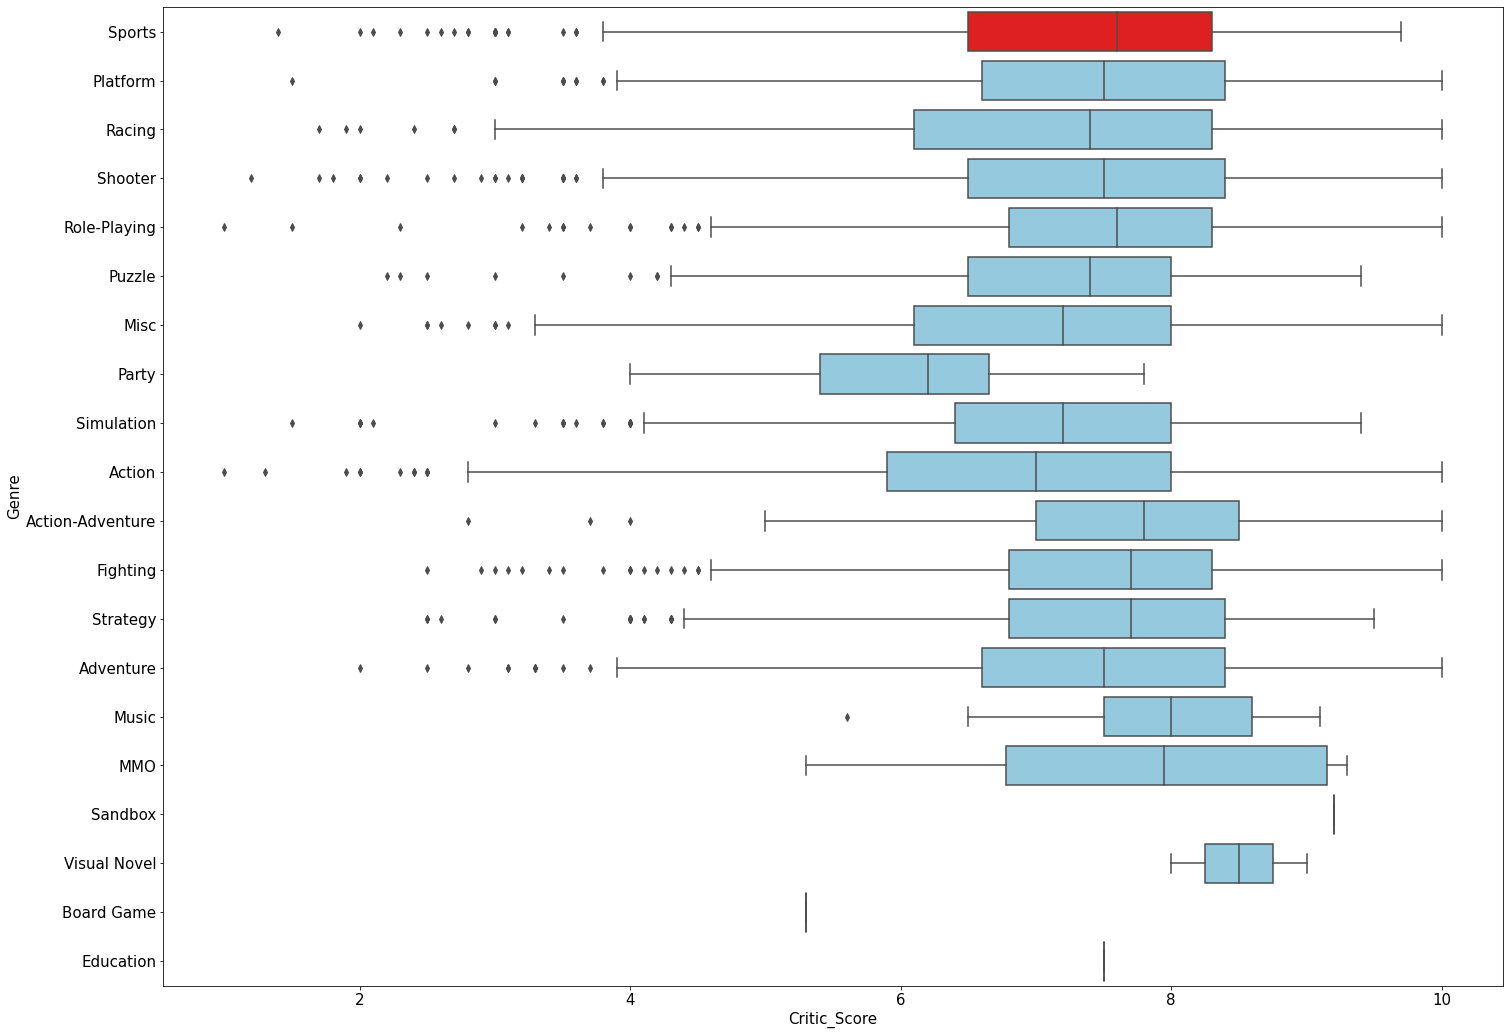

In [21]:
# посмотрим на boxplot распределения оценок играм

fig, ax = plt.subplots(figsize=(24,18))
my_pal = {genre: "r" if genre == "Sports" else "skyblue" for genre in games_df.Genre.unique()}
sns.boxplot(
    y="Genre", x="Critic_Score",
    data=videogames_df[['Genre', 'Critic_Score']],
    orient='h',
    palette=my_pal,
    ax=ax
)

# Спортивные игры действительно имеют достаточно "среднее" распределение оценок,
# похожее на большинство.


#Вариант 2. Tukey HSD test

Н0: средние оценки всех жанров игр равны между собой
Н1: среднее оценки как минимум двух жанров не равны

Пороговый уровень статистической значимости = 0,05


In [23]:
# Проводим Tukey HSD test
result_tukey = pairwise_tukeyhsd(endog=games_df['Critic_Score'], groups=games_df['Genre'], alpha=0.05)

# Сохраняем результаты в формате датасета
tukey_result_df = pd.DataFrame(
    result_tukey.summary(), columns=['group1','group2','meandiff','p-adj','lower','upper','reject']
)

# Первая строка датасета дублирует название колонок, удалим
tukey_result_df = tukey_result_df.iloc[1:]
tukey_result_df


,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Action-Adventure,0.8537,0.001,0.3177,1.3897,True
2,Action,Adventure,0.489,0.001,0.187,0.7909,True
3,Action,Board Game,-1.5402,0.9,-6.6353,3.5548,False
4,Action,Education,0.6598,0.9,-4.4353,5.7548,False
5,Action,Fighting,0.5482,0.001,0.2251,0.8713,True
...,...,...,...,...,...,...,...
186,Simulation,Strategy,0.5031,0.0051,0.0747,0.9315,True
187,Simulation,Visual Novel,1.5738,0.9,-2.0429,5.1905,False
188,Sports,Strategy,0.1378,0.9,-0.1908,0.4664,False
189,Sports,Visual Novel,1.2086,0.9,-2.3977,4.8148,False


In [25]:
# Меняем типы данных
tukey_result_df = tukey_result_df.astype(str)
tukey_result_df[['meandiff','p-adj','lower','upper']] = tukey_result_df[['meandiff','p-adj','lower','upper']].astype(float)

# Убираем лишние пары сравнений, оставляем только пары со Sports
tukey_result_df[
    (tukey_result_df['group1'] == 'Sports') |
    (tukey_result_df['group2'] == 'Sports')
]

,group1,group2,meandiff,p-adj,lower,upper,reject
17,Action,Sports,0.4512,0.0010,0.2001,0.7022,True
35,Action-Adventure,Sports,-0.4025,0.5001,-0.9499,0.1449,False
52,Adventure,Sports,-0.0378,0.9000,-0.3595,0.2840,False
68,Board Game,Sports,1.9914,0.9000,-3.1049,7.0877,False
83,Education,Sports,-0.2086,0.9000,-5.3049,4.8877,False
97,Fighting,Sports,-0.0970,0.9000,-0.4387,0.2447,False
110,MMO,Sports,-0.5186,0.9000,-2.1407,1.1035,False
122,Misc,Sports,0.4056,0.0035,0.0674,0.7439,True
133,Music,Sports,-0.6206,0.8200,-1.6574,0.4163,False
143,Party,Sports,1.2381,0.1055,-0.0911,2.5672,False


c:\users\ivnat\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


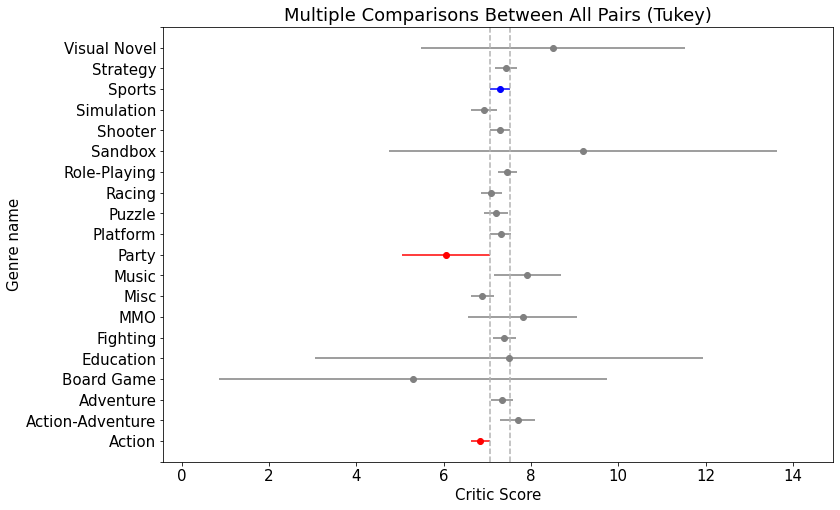

In [26]:
# Визуализируем результаты на графике
result_tukey.plot_simultaneous(
    figsize=(12, 8),
    comparison_name='Sports',
    ax=None,
    xlabel='Critic Score',
    ylabel='Genre name'
)
plt.show()

**Вывод:**

С помощью теста Тьюки мы установили,
что есть статистически значимые различия между оценками спортивных игр и игр жанров Party и Action.

В паре Action - Sport (p-value = 0.0010), игры жанра Action в среднем оцениваются ниже Sport.

В паре Party-Sports (p-value =0.0035), игры жанра Party в среднем оцениваются ниже Sport.

Разница в оценке между спортивными играми и другими жанрами не является статистически значимой -
средняя оценка спортивных игр входит в доверительный интервал распределений оценок других жанров.

Таким образом можно сказать, что критики относятся к спортивным играм лучше, чем к жанрам Party и Action.
Но, скорее не потому что предпочитают спортивные игры (их они оценивают примерно так же как игры других жанров и все игры в среднем),
а потому что ниже оценивают жанры Party и Action.


### Критикам нравятся больше игры на PC или на PS4?

**Paired t-test for independent samples**

Н0: средние оценки двух выборок равны
Н1: среднее оценки двух выборок не равны

Пороговый уровень статистической значимости = 0,05


<AxesSubplot:xlabel='Critic_Score', ylabel='Platform'>

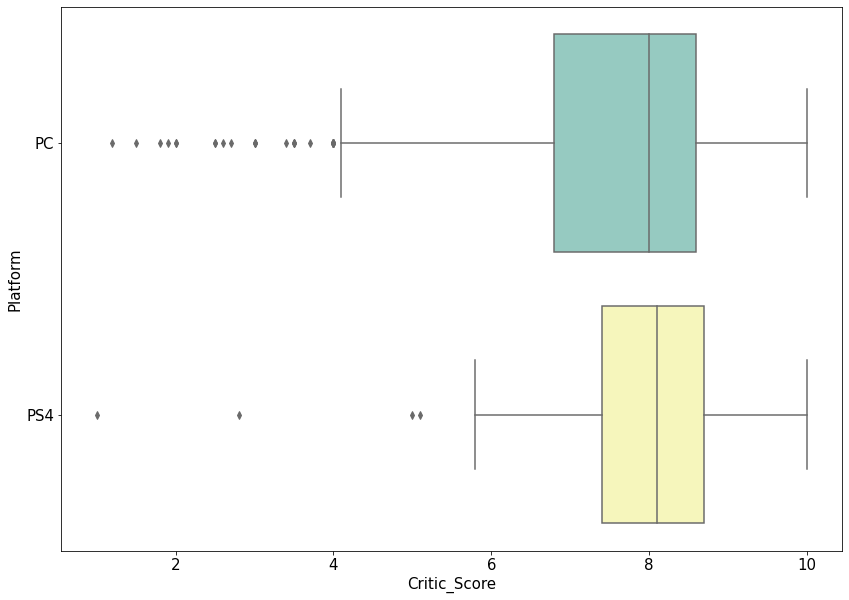

In [27]:
# Оставляем только игры для PC и PS4
videogames_pc_ps4 = games_df[ (games_df['Platform'] == 'PC') |
               (games_df['Platform'] == 'PS4') ][['Platform', 'Critic_Score']]

# Визуализируем распределения с помощью boxplot
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(
    y="Platform", x="Critic_Score",
    data=videogames_pc_ps4,
    palette="Set3",
    ax=ax
)


Медианы обеих групп находятся практически на одной отметке и входят в доверительные интервалы друг друга,
возможно статистически значимых различий не будет.


Условия применения two sample t-test на независимых выборках:
- Нормальность распределения (при объеме выборки n< 30).
- Гомогенность дисперсий


Critic_Score normality check 

Shapiro-Wilk normality test for Critic_Score
Statistics=0.907, p-value=0.0% 

Shapiro-Wilk: Sample does not look Gaussian (can reject H0) 

D’Agostino’s K^2 normality Test test for Critic_Score
Statistics=191.827, p-value=0.0% 

D’Agostino’s: Sample does not look Gaussian (can reject H0) 



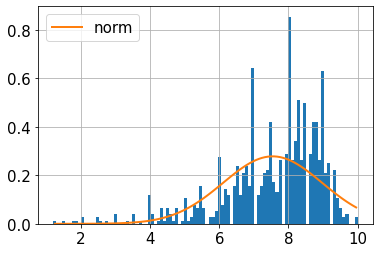

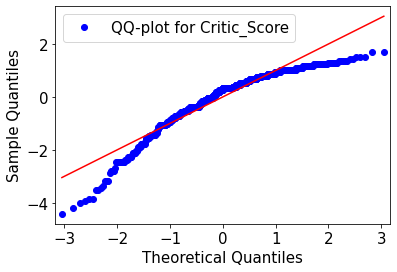

In [28]:
# Для PC

# статистическая проверка на нормальность
statistical_normality_test(feature_name='Critic_Score', df_name=games_df[ games_df['Platform'] == 'PC' ], alpha=0.05)

# визуальная проверка на нормальность
visual_normality_check(feature_name='Critic_Score', df_name=games_df[ games_df['Platform'] == 'PC' ])

# Оценки для PC не распределены нормально


Critic_Score normality check 

Shapiro-Wilk normality test for Critic_Score
Statistics=0.847, p-value=0.0% 

Shapiro-Wilk: Sample does not look Gaussian (can reject H0) 

D’Agostino’s K^2 normality Test test for Critic_Score
Statistics=70.442, p-value=0.0% 

D’Agostino’s: Sample does not look Gaussian (can reject H0) 



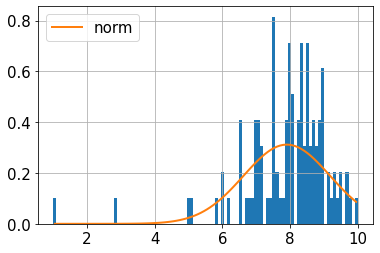

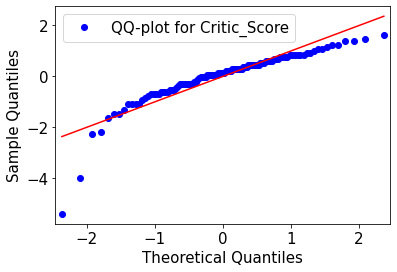

In [29]:
# Для PS4

# статистическая проверка на нормальность
statistical_normality_test(feature_name='Critic_Score', df_name=games_df[ games_df['Platform'] == 'PS4' ], alpha=0.05)

# визуальная проверка на нормальность
visual_normality_check(feature_name='Critic_Score', df_name=games_df[ games_df['Platform'] == 'PS4' ])

# Оценки для PS4 так же не распределены нормально


In [30]:
# Разделим выборки на две группы для проведения проверок
pc_critic_score = games_df[ games_df['Platform'] == 'PC' ]['Critic_Score']
ps4_critic_score = games_df[ games_df['Platform'] == 'PS4' ]['Critic_Score']

In [31]:
# Сделаем проверку на гомогенность дисперсий
W, p_lev = st.levene(pc_critic_score, ps4_critic_score)
print(
          f'Levene test для оценки гомогенности дисперсий оценок игр для PC и PS4\n'
          f'Statistics={np.round(W, 3)}, p-value={np.round(p_lev, 3)} \n'
     )

alpha = 0.05
if p_lev > alpha:
    print('Levene: Samples have equal variances (fail to reject H0) \n')
else:
    print('Levene: Samples variances are not equal (can reject H0) \n')

Levene test для оценки гомогенности дисперсий оценок игр для PC и PS4
Statistics=3.881, p-value=0.049 

Levene: Samples variances are not equal (can reject H0) 



Учитывая негомогенность дисперсий, t-test нужно проводить с поправкой Уэлча.
Учитывая размеры выборок, можно проигнорировать то, что переменная не распределена согласно нормальному закону.

In [34]:
# Welch t-test
result_platforms = st.ttest_ind(
    pc_critic_score,
    ps4_critic_score,
    equal_var=False
)
print(
        f'Independent Welch t-test results:\n'
        f'Statistic={round(result_platforms.statistic,3)}, p-value={round(result_platforms.pvalue, 3)}% \n'
    )

# Independent Welch t-test interpret
if result_platforms.pvalue > alpha:
    print(
        'Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. \n'
          )
else:
    print(
        'Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. \n'
    )

Independent Welch t-test results:
Statistic=-2.739, p-value=0.007% 

Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. 



**Вывод:**
Распределения оценок игр для PC и PS4 отличаются значимо, p-value < 0.05 (p = 0.007).
Значение t-value -2.7, что говорит о том, что в среднем критики оценивают игры на PS4 выше игр на PC (на 2,7 в единицах
суммарного стандартного отклонения)

Но, в данных много выбросов, особенно для PC, а t-test основывается на средних значениях, которые зависимы от выбросов.
Проверим надежность результата: не поменяется ли результат, если исключить выбросы.


In [35]:
# Убираем выбросы для PC
pc_z_scores = np.abs(st.zscore(pc_critic_score))    # переводим значения в z-value
videogames_pc = videogames_pc_ps4[ videogames_df['Platform'] == 'PC' ]  # оставляем только игры для PC
videogames_pc['Z-Score'] = pd.Series(pc_z_scores, index=videogames_pc.index)    # добавляем в отдельную колонку z-values
videogames_pc_no_outl = videogames_pc[ videogames_pc['Z-Score'] < 3]    # убираем выбросы
videogames_pc_no_outl.describe()


C:\Users\ivnat\AppData\Local\Temp/ipykernel_18392/2347024048.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  videogames_pc = videogames_pc_ps4[ videogames_df['Platform'] == 'PC' ]  # оставляем только игры для PC
C:\Users\ivnat\AppData\Local\Temp/ipykernel_18392/2347024048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames_pc['Z-Score'] = pd.Series(pc_z_scores, index=videogames_pc.index)    # добавляем в отдельную колонку z-values


,Critic_Score,Z-Score
count,852.000000,852.000000
mean,7.622066,0.730961
std,1.287482,0.523339
min,3.400000,0.029177
25%,6.900000,0.319411
50%,8.000000,0.667998
75%,8.600000,1.016585
max,10.000000,2.887591


In [36]:
# Убираем выбросы для PS4
ps4_z_scores = np.abs(st.zscore(ps4_critic_score))  # переводим значения в z-value
videogames_ps4 = videogames_pc_ps4[ videogames_df['Platform'] == 'PS4' ]  # оставляем только игры для PS4
videogames_ps4['Z-Score'] = pd.Series(ps4_z_scores, index=videogames_ps4.index)     # добавляем в отдельную колонку z-values
videogames_ps4_no_outl = videogames_ps4[ videogames_ps4['Z-Score'] < 3]    # убираем выбросы
videogames_ps4_no_outl.describe()


C:\Users\ivnat\AppData\Local\Temp/ipykernel_18392/563772307.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  videogames_ps4 = videogames_pc_ps4[ videogames_df['Platform'] == 'PS4' ]  # оставляем только игры для PS4
C:\Users\ivnat\AppData\Local\Temp/ipykernel_18392/563772307.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames_ps4['Z-Score'] = pd.Series(ps4_z_scores, index=videogames_ps4.index)     # добавляем в отдельную колонку z-values


,Critic_Score,Z-Score
count,107.000000,107.000000
mean,8.016822,0.620958
std,0.987133,0.462619
min,5.000000,0.003586
25%,7.500000,0.309105
50%,8.100000,0.543623
75%,8.700000,0.856314
max,10.000000,2.270594


In [37]:
# Убираем z-value из датасета
pc_no_outl_critic_score = videogames_pc_no_outl['Critic_Score']
ps4_no_outl_critic_score = videogames_ps4_no_outl['Critic_Score']

# Повторяем t-test с поправкой Уэлча
result_platforms_no_outl = st.ttest_ind(
    pc_no_outl_critic_score,
    ps4_no_outl_critic_score,
    equal_var=False
)
print(
        f'Independent t-test results:\n'
        f'Statistic={round(result_platforms_no_outl.statistic,3)}, p-value={round(result_platforms_no_outl.pvalue, 4)}% \n'
    )
# Independent t-test interpret
if result_platforms_no_outl.pvalue > alpha:
    print(
        'Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. \n'
          )
else:
    print(
        'Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. \n'
    )


Independent t-test results:
Statistic=-3.755, p-value=0.0002% 

Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. 



**Вывод:**
После удаления выбросов, результаты предыдущего теста подтвердились, несмотря на то,
что визуальнj статистически значимая разница была не очевидна.

Различия значимы, при p-value < 0.05 (p = 0.0002). Значение p-value уменьшилось еще сильнее,
что говорит о больших основаниях в пользу отклонения гипотезы H0.

Значение t-value -3,75, что так же подтверждает - критики в среднем выше оценивают игры на PS4.


### Критикам больше нравятся стрелялки или стратегии?

Вариант1. Paired t-test for independent samples

Н0: средние оценки двух выборок равны
Н1: среднее оценки двух выборок не равны

Пороговый уровень статистической значимости = 0,05

<AxesSubplot:xlabel='Critic_Score', ylabel='Genre'>

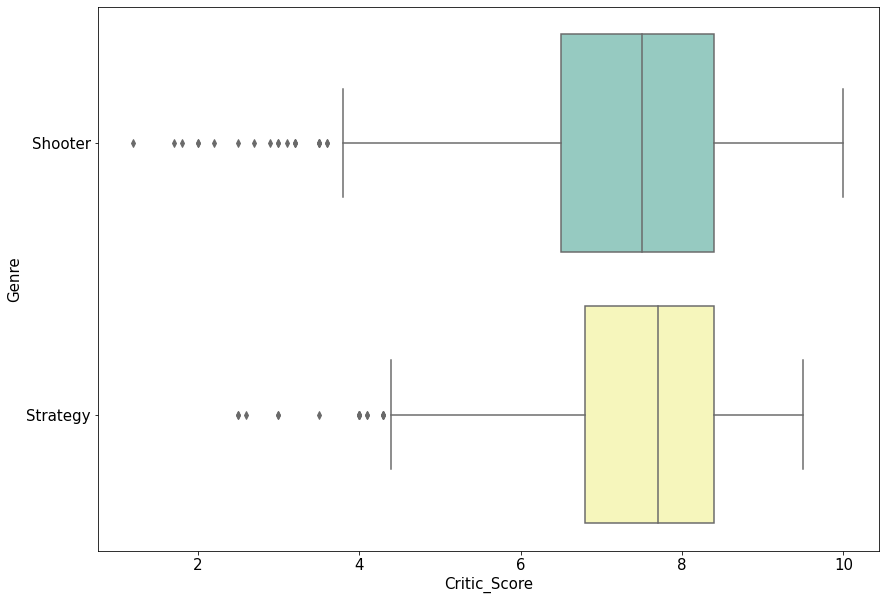

In [38]:
# Оставляем только игры с жанрами шутер и стратегия
shooter_strategy = games_df[
    ( games_df['Genre'] == 'Shooter' ) |
    ( games_df['Genre'] == 'Strategy' )
]

# Визуализируем распределения с помощью boxplot
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(
    y="Genre", x="Critic_Score",
    data=shooter_strategy,
    palette="Set3",
    ax=ax
)


Critic_Score normality check 

Shapiro-Wilk normality test for Critic_Score
Statistics=0.943, p-value=0.0% 

Shapiro-Wilk: Sample does not look Gaussian (can reject H0) 

D’Agostino’s K^2 normality Test test for Critic_Score
Statistics=113.208, p-value=0.0% 

D’Agostino’s: Sample does not look Gaussian (can reject H0) 



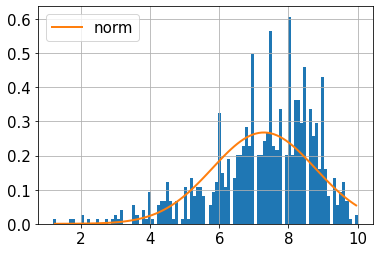

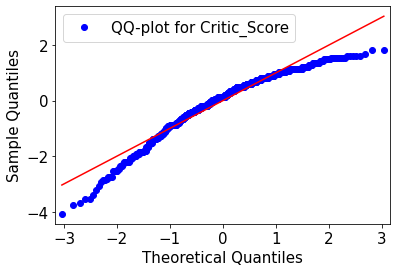

In [39]:
# Для Shooter

# статистическая проверка на нормальность
statistical_normality_test(feature_name='Critic_Score', df_name=games_df[ games_df['Genre'] == 'Shooter'], alpha=0.05)

# визуальная проверка на нормальность
visual_normality_check(feature_name='Critic_Score', df_name=games_df[ games_df['Genre'] == 'Shooter' ])

# Оценки для Shooter не распределены нормально


Critic_Score normality check 

Shapiro-Wilk normality test for Critic_Score
Statistics=0.916, p-value=0.0% 

Shapiro-Wilk: Sample does not look Gaussian (can reject H0) 

D’Agostino’s K^2 normality Test test for Critic_Score
Statistics=66.193, p-value=0.0% 

D’Agostino’s: Sample does not look Gaussian (can reject H0) 



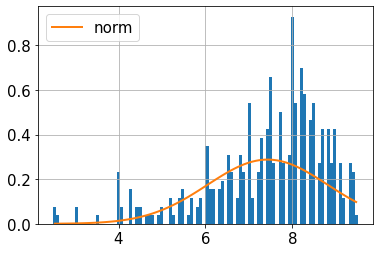

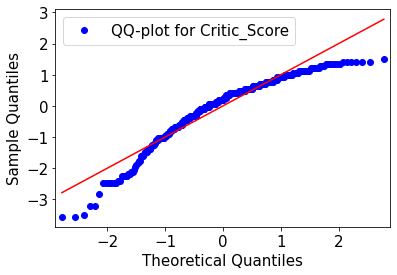

In [40]:
# Для Strategy

# статистическая проверка на нормальность
statistical_normality_test(feature_name='Critic_Score', df_name=games_df[ games_df['Genre'] == 'Strategy'], alpha=0.05)

# визуальная проверка на нормальность
visual_normality_check(feature_name='Critic_Score', df_name=games_df[ games_df['Genre'] == 'Strategy' ])

# Оценки для Strategy не распределены нормально


In [41]:
# Разделим выборки на две группы для проведения проверок
shooter_scores = shooter_strategy[ shooter_strategy['Genre'] == 'Shooter' ]['Critic_Score']
strategy_scores = shooter_strategy[ shooter_strategy['Genre'] == 'Strategy' ]['Critic_Score']

In [42]:
# Сделаем проверку на гомогенность дисперсий
W, p_lev = st.levene(shooter_scores, strategy_scores)
print(
          f'Levene test для оценки гомогенности дисперсий оценок игр для PC и PS4\n'
          f'Statistics={np.round(W, 3)}, p-value={np.round(p_lev, 3)} \n'
     )

alpha = 0.05
if p_lev > alpha:
    print('Levene: Samples have equal variances (fail to reject H0) \n')
else:
    print('Levene: Samples variances are not equal (can reject H0) \n')


Levene test для оценки гомогенности дисперсий оценок игр для PC и PS4
Statistics=3.08, p-value=0.079 

Levene: Samples have equal variances (fail to reject H0) 



Распределения не нормальные, но дисперсии гомогенны. Можно проводить обычный t-test.
В данных есть выбросы, поэтому проведем два теста - с выбросами и без.


In [44]:
# Independent t-test
result_shooter_strategy = st.ttest_ind(
    shooter_scores,strategy_scores
)

print(
        f'One sample t-test results:\n'
        f'Statistic={round(result_shooter_strategy.statistic,3)}, p-value={round(result_shooter_strategy.pvalue, 3)}% \n'
    )
# Independent t-test interpretation
if result_shooter_strategy.pvalue > alpha:
    print(
        'Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. \n'
          )
else:
    print(
        'Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. \n'
    )

One sample t-test results:
Statistic=-1.562, p-value=0.119% 

Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. 



In [45]:
#убираем выбросы для Shooters
shooter_z_scores = np.abs(st.zscore(shooter_scores))
videogames_shooters = shooter_strategy[ shooter_strategy['Genre'] == 'Shooter' ][['Genre', 'Critic_Score']]
videogames_shooters['Z-Score'] = pd.Series(shooter_z_scores, index=videogames_shooters.index)
videogames_shooters_no_outl = videogames_shooters[ videogames_shooters['Z-Score'] < 3]
videogames_shooters_no_outl.describe()

,Critic_Score,Z-Score
count,835.000000,835.000000
mean,7.337365,0.757434
std,1.406125,0.561784
min,2.900000,0.008828
25%,6.550000,0.326414
50%,7.500000,0.679314
75%,8.400000,1.063949
max,10.000000,2.941309


In [46]:
#убираем выбросы для Strategy
strategy_z_scores = np.abs(st.zscore(strategy_scores))
videogames_strategy = shooter_strategy[ shooter_strategy['Genre'] == 'Strategy' ][['Genre', 'Critic_Score']]
videogames_strategy['Z-Score'] = pd.Series(strategy_z_scores, index=videogames_strategy.index)
videogames_strategy_no_outl = videogames_strategy[ videogames_strategy['Z-Score'] < 3]
videogames_strategy_no_outl.describe()


,Critic_Score,Z-Score
count,364.000000,364.000000
mean,7.493956,0.737999
std,1.280116,0.557393
min,3.500000,0.021137
25%,6.800000,0.339951
50%,7.800000,0.628821
75%,8.400000,1.032182
max,9.500000,2.837620


In [51]:
# Разделяем данные
shooters_no_outl_critic_score = videogames_shooters_no_outl['Critic_Score']
strategy_no_outl_critic_score = videogames_strategy_no_outl['Critic_Score']

# Independent t-test
result_shooter_strategy_no_outl = st.ttest_ind(
    shooters_no_outl_critic_score, strategy_no_outl_critic_score
)

print(
        f'One sample t-test results:\n'
        f'Statistic={round(result_shooter_strategy_no_outl.statistic,3)}, '
        f'p-value={round(result_shooter_strategy_no_outl.pvalue, 3)}% \n'
    )
# Independent t-test interpretation
if result_shooter_strategy_no_outl.pvalue > alpha:
    print(
        'Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. \n'
          )
else:
    print(
        'Порог статистической значимости достигнут. Есть основания отвергнуть гипотезу H0. \n'
    )


One sample t-test results:
Statistic=-1.821, p-value=0.069% 

Порог статистической значимости не достигнут. Недостаточно оснований отвергнуть гипотезу H0. 



In [49]:
# Проверим результат теста Tukey для этой пары
tukey_result_df[
    (tukey_result_df['group1'] == 'Shooter') &
    (tukey_result_df['group2'] == 'Strategy')
]

,group1,group2,meandiff,p-adj,lower,upper,reject
183,Shooter,Strategy,0.1424,0.9,-0.1754,0.4603,False


c:\users\ivnat\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


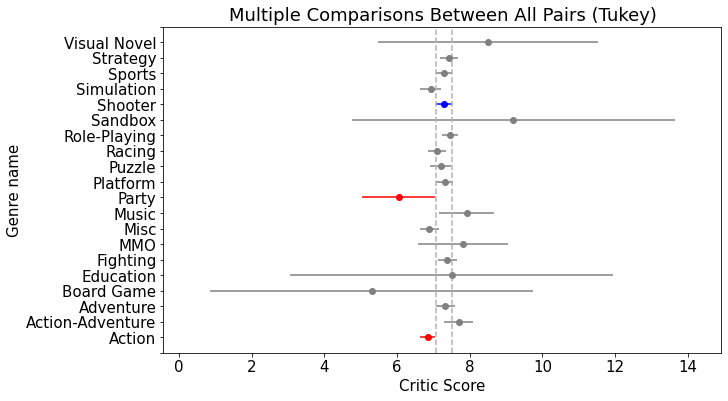

In [50]:
# Визуализируем результат теста Tuckey, выделив Shooter
result_tukey.plot_simultaneous(
    figsize=(10, 6),
    comparison_name='Shooter',
    xlabel='Critic Score',
    ylabel='Genre name',
    ax=None,
)
plt.show()

**Вывод:**
Все проведенные тесты говорят о том, что значимых различий между распределением оценок жанров Shooter и Strategy - нет.

1. t-test с поправкой на разность дисперсий, с выбросами в данных - p-value=0.119%
2. t-test с поправкой на разность дисперсий, без выбросов в данных - p-value=0.069%
3. Tukey HSK, p-value = 0.9

Мы можем сказать, что в среднем критики одинаково относятся к шутерам и стратегиям



